In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
import time, pickle

from sklearn import datasets, linear_model
from genetic_selection import GeneticSelectionCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression, ElasticNet,RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate, KFold, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import balanced_accuracy_score, make_scorer, roc_auc_score, accuracy_score
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/home/e0205142/project/MIMIC_assignment1/data/train.csv')
df

,icustay id,Capillary refill rate,Diastolic blood pressure,Fraction inspired oxygen,Glascow coma scale eye opening,Glascow coma scale motor response,Glascow coma scale total,Glascow coma scale verbal response,Glucose,Heart Rate,Height,Mean blood pressure,Oxygen saturation,Respiratory rate,Systolic blood pressure,Temperature,Weight,pH,label
0,58313_episode1_timeseries.csv,NaN,74.0,0.95,Spontaneously,Localizes Pain,NaN,Confused,140.0,100.0,NaN,91.0,96.0,25.0,141.0,37.055556,52.389876,7.40,0.0
1,9498_episode1_timeseries.csv,NaN,46.0,NaN,4 Spontaneously,6 Obeys Commands,15.0,5 Oriented,127.0,93.0,NaN,61.0,94.0,19.0,96.0,36.000002,NaN,7.37,0.0
2,31641_episode2_timeseries.csv,NaN,48.0,NaN,To Speech,Obeys Commands,NaN,Oriented,138.0,66.0,NaN,72.0,97.0,16.0,115.0,36.111111,71.350022,NaN,0.0
3,66015_episode2_timeseries.csv,NaN,52.0,0.40,None,No response,NaN,No Response-ETT,137.0,84.0,NaN,66.0,99.0,9.0,108.0,36.611111,68.265596,7.26,0.0
4,51795_episode1_timeseries.csv,NaN,85.0,NaN,Spontaneously,Obeys Commands,NaN,Oriented,144.0,114.0,NaN,96.0,97.0,30.0,132.0,37.055556,78.017824,7.48,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17898,76799_episode1_timeseries.csv,NaN,82.0,1.00,Spontaneously,Obeys Commands,NaN,Oriented,147.0,86.0,157.0,87.0,99.0,16.0,144.0,36.888889,90.809118,6.50,0.0
17899,99288_episode1_timeseries.csv,NaN,35.0,0.40,To Speech,Obeys Commands,NaN,No Response-ETT,184.0,64.0,NaN,61.0,100.0,16.0,137.0,36.777778,117.000000,7.36,0.0
17900,29502_episode2_timeseries.csv,NaN,71.0,NaN,4 Spontaneously,6 Obeys Commands,15.0,5 Oriented,88.0,102.0,NaN,83.0,98.0,17.0,125.0,37.055599,71.000000,5.50,0.0
17901,77280_episode1_timeseries.csv,NaN,62.0,NaN,Spontaneously,Obeys Commands,NaN,Confused,119.0,67.0,NaN,73.0,100.0,11.0,114.0,35.555556,74.000000,7.42,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17903 entries, 0 to 17902
Data columns (total 19 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   icustay id                          17903 non-null  object 
 1   Capillary refill rate               323 non-null    float64
 2   Diastolic blood pressure            17689 non-null  float64
 3   Fraction inspired oxygen            5309 non-null   float64
 4   Glascow coma scale eye opening      17739 non-null  object 
 5   Glascow coma scale motor response   17737 non-null  object 
 6   Glascow coma scale total            10387 non-null  float64
 7   Glascow coma scale verbal response  17736 non-null  object 
 8   Glucose                             17886 non-null  float64
 9   Heart Rate                          17689 non-null  float64
 10  Height                              3385 non-null   float64
 11  Mean blood pressure                 17687

In [4]:
df.describe()

,Capillary refill rate,Diastolic blood pressure,Fraction inspired oxygen,Glascow coma scale total,Glucose,Heart Rate,Height,Mean blood pressure,Oxygen saturation,Respiratory rate,Systolic blood pressure,Temperature,Weight,pH,label
count,323.000000,17689.000000,5309.000000,10387.000000,17886.000000,17689.000000,3385.000000,17687.000000,17783.000000,17683.000000,17689.000000,17554.000000,1.305200e+04,14776.000000,17903.000000
mean,0.229102,71.121262,0.734140,10.260903,155.349435,89.817288,168.548597,82.512712,96.600045,18.210202,123.949799,36.604080,7.135584e+02,7.092986,0.135340
std,0.420907,757.341034,0.264228,4.780035,113.680344,21.932248,14.862592,50.767863,6.343250,6.940607,25.984069,1.284341,7.212364e+04,2.137607,0.342096
min,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,-34.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,0.000000,53.000000,0.500000,6.000000,109.000000,76.000000,160.000000,69.333298,96.000000,14.000000,106.000000,36.013890,6.600000e+01,7.230000,0.000000
50%,0.000000,63.000000,0.700000,11.000000,135.000000,88.000000,170.000000,80.000000,98.000000,18.000000,121.000000,36.611112,7.860000e+01,7.350000,0.000000
75%,0.000000,74.000000,1.000000,15.000000,173.000000,102.000000,178.000000,93.000000,100.000000,22.000000,140.000000,37.166698,9.400000e+01,7.420000,0.000000
max,1.000000,100105.010000,1.990000,15.000000,9999.000000,941.000000,429.000000,6350.000000,100.000000,115.000000,281.000000,60.000000,8.239872e+06,100.000000,1.000000


**Dtype of Glascow coma scale eye opening, Glascow coma scale motor response, Glascow coma scale verbal response is object. They should be checked and updated.**

## 1. Clean data

### 1.1 fix outliers

In [5]:
df['Diastolic blood pressure'] = df['Diastolic blood pressure'].mask(df['Diastolic blood pressure']>150, np.nan)
df['Fraction inspired oxygen'] = df['Fraction inspired oxygen'].mask(df['Fraction inspired oxygen']>1, np.nan)
df['Glucose'] = df['Glucose'].mask(df['Glucose']>1250, np.nan)
df['Heart Rate'] = df['Heart Rate'].mask(df['Heart Rate']>300, np.nan)
df['Height'] = df['Height'].mask((df['Height']>250) | (df['Height']<= 0), np.nan)
df['Mean blood pressure'] = df['Mean blood pressure'].mask((df['Mean blood pressure']>190) | (df['Mean blood pressure'] <= 0), np.nan)
df['Systolic blood pressure'] = df['Systolic blood pressure'].mask((df['Systolic blood pressure'] > 275) | (df['Systolic blood pressure']<=0), np.nan)
df['Temperature'] = df['Temperature'].mask((df['Temperature']>49) | (df['Temperature'] < 20), np.nan)
df['Weight'] = df['Weight'].mask(df['Weight'] > 250, np.nan)
df['pH'] = df['pH'].mask((df['pH'] > 8) | (df['pH'] < 6), np.nan)


In [6]:
df.describe()

,Capillary refill rate,Diastolic blood pressure,Fraction inspired oxygen,Glascow coma scale total,Glucose,Heart Rate,Height,Mean blood pressure,Oxygen saturation,Respiratory rate,Systolic blood pressure,Temperature,Weight,pH,label
count,323.000000,17675.000000,5308.000000,10387.000000,17883.000000,17687.000000,3382.000000,17664.000000,17783.000000,17683.000000,17676.000000,17545.000000,13041.000000,13026.000000,17903.000000
mean,0.229102,64.293409,0.733904,10.260903,154.662920,89.723356,168.571260,82.087485,96.600045,18.210202,124.025062,36.619437,82.061271,7.300895,0.135340
std,0.420907,17.154907,0.263690,4.780035,85.670512,20.074608,13.572903,18.210046,6.343250,6.940607,25.765027,1.003978,24.337755,0.283119,0.342096
min,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,13.000000,2.000000,0.000000,0.000000,11.000000,26.666700,0.000000,6.000000,0.000000
25%,0.000000,53.000000,0.500000,6.000000,109.000000,76.000000,160.000000,69.333298,96.000000,14.000000,106.000000,36.055556,66.000000,7.290000,0.000000
50%,0.000000,62.000000,0.700000,11.000000,135.000000,88.000000,170.000000,80.000000,98.000000,18.000000,121.000000,36.611112,78.599998,7.370000,0.000000
75%,0.000000,74.000000,1.000000,15.000000,173.000000,102.000000,178.000000,93.000000,100.000000,22.000000,140.000000,37.166698,94.000000,7.430000,0.000000
max,1.000000,149.000000,1.000000,15.000000,1210.000000,190.000000,209.000000,188.000000,100.000000,115.000000,268.000000,42.000000,250.000000,8.000000,1.000000


### 1.2 fix 'Glascow coma scale eye opening' variable

In [7]:
df['Glascow coma scale eye opening'].value_counts()

4 Spontaneously    5239
Spontaneously      3965
1 No Response      3135
None               1915
3 To speech        1391
To Speech           956
2 To pain           674
To Pain             464
Name: Glascow coma scale eye opening, dtype: int64

The numbers at the beginning of strings should be removed.

In [8]:
#df['Glascow coma scale eye opening'] = 
df['Glascow coma scale eye opening'].value_counts()

4 Spontaneously    5239
Spontaneously      3965
1 No Response      3135
None               1915
3 To speech        1391
To Speech           956
2 To pain           674
To Pain             464
Name: Glascow coma scale eye opening, dtype: int64

In [9]:
label_m = {
    'None': '1 No Response',
    'No Response': '1 No Response',
    'To Pain': '2 To pain',
    'To Speech': '3 To speech',
    'Spontaneously': '4 Spontaneously'
}

for orig, target in label_m.items():
    df['Glascow coma scale eye opening'] = df['Glascow coma scale eye opening'].replace(orig, target)

df['Glascow coma scale eye opening'].value_counts()

4 Spontaneously    9204
1 No Response      5050
3 To speech        2347
2 To pain          1138
Name: Glascow coma scale eye opening, dtype: int64

### 1.3 fix 'Glascow coma scale motor response' variable

In [10]:
df['Glascow coma scale motor response'].value_counts()

6 Obeys Commands      5908
Obeys Commands        4476
1 No Response         2316
5 Localizes Pain      1392
No response           1305
Localizes Pain         820
4 Flex-withdraws       689
Flex-withdraws         579
3 Abnorm flexion        80
Abnormal extension      66
2 Abnorm extensn        54
Abnormal Flexion        52
Name: Glascow coma scale motor response, dtype: int64

In [11]:
label_m = {
    'No response': '1 No Response',
    'Abnormal extension': '2 Abnorm extensn',
    'Abnormal Flexion': '3 Abnorm flexion',
    'Flex-withdraws': '4 Flex-withdraws',
    'Localizes Pain':'5 Localizes Pain',
    'Obeys Commands':'6 Obeys Commands'
}

for orig, target in label_m.items():
    df['Glascow coma scale motor response'] = df['Glascow coma scale motor response'].replace(orig, target)

df['Glascow coma scale motor response'].value_counts()

6 Obeys Commands    10384
1 No Response        3621
5 Localizes Pain     2212
4 Flex-withdraws     1268
3 Abnorm flexion      132
2 Abnorm extensn      120
Name: Glascow coma scale motor response, dtype: int64

### 1.3 fix 'Glascow coma scale verbal response' variable

In [12]:
df['Glascow coma scale verbal response'].value_counts()

1.0 ET/Trach               4975
5 Oriented                 4224
Oriented                   3332
No Response-ETT            2787
4 Confused                  647
Confused                    621
No Response                 384
1 No Response               355
2 Incomp sounds             181
Incomprehensible sounds     136
3 Inapprop words             57
Inappropriate Words          37
Name: Glascow coma scale verbal response, dtype: int64

1.0 ET/Trach stands for endotracheal (ET) tube/tracheostomy tube.

In [13]:
label_m = {
    '1.0 ET/Trach': '0 ET/Trach',
    'No Response-ETT': '0 No Response-ETT',
    'No Response': '1 No Response',
    'Incomprehensible sounds': '2 Incomp sounds',
    'Inappropriate Words': '3 Inapprop words',
    'Confused': '4 Confused',
    'Oriented':'5 Oriented',
}

for orig, target in label_m.items():
    df['Glascow coma scale verbal response'] = df['Glascow coma scale verbal response'].replace(orig, target)

df['Glascow coma scale verbal response'].value_counts()

5 Oriented           7556
0 ET/Trach           4975
0 No Response-ETT    2787
4 Confused           1268
1 No Response         739
2 Incomp sounds       317
3 Inapprop words       94
Name: Glascow coma scale verbal response, dtype: int64

In [14]:
df['Glascow coma scale eye opening'].value_counts()

4 Spontaneously    9204
1 No Response      5050
3 To speech        2347
2 To pain          1138
Name: Glascow coma scale eye opening, dtype: int64

check NAs

In [15]:
df.isnull().sum()

icustay id                                0
Capillary refill rate                 17580
Diastolic blood pressure                228
Fraction inspired oxygen              12595
Glascow coma scale eye opening          164
Glascow coma scale motor response       166
Glascow coma scale total               7516
Glascow coma scale verbal response      167
Glucose                                  20
Heart Rate                              216
Height                                14521
Mean blood pressure                     239
Oxygen saturation                       120
Respiratory rate                        220
Systolic blood pressure                 227
Temperature                             358
Weight                                 4862
pH                                     4877
label                                     0
dtype: int64

In [16]:
df.isnull().sum()/len(df)

icustay id                            0.000000
Capillary refill rate                 0.981958
Diastolic blood pressure              0.012735
Fraction inspired oxygen              0.703513
Glascow coma scale eye opening        0.009160
Glascow coma scale motor response     0.009272
Glascow coma scale total              0.419818
Glascow coma scale verbal response    0.009328
Glucose                               0.001117
Heart Rate                            0.012065
Height                                0.811093
Mean blood pressure                   0.013350
Oxygen saturation                     0.006703
Respiratory rate                      0.012288
Systolic blood pressure               0.012679
Temperature                           0.019997
Weight                                0.271575
pH                                    0.272412
label                                 0.000000
dtype: float64

In [17]:
df['label'].value_counts()

0.0    15480
1.0     2423
Name: label, dtype: int64

**2423/(2423+15480) patients deceased. Imbalanced data. This is a problem as it is typically the minority class on which predictions are most important.**

In [18]:
# save corrected dataset
df.to_csv('/home/e0205142/project/MIMIC_assignment1/data/train_corrected.csv', index=False)

### 1.4 change ordinal features from string to integer

In [19]:
df['Glascow coma scale eye opening'] = df['Glascow coma scale eye opening'].str.split(' ').str[0]

In [20]:
df['Glascow coma scale motor response'] = df['Glascow coma scale motor response'].str.split(' ').str[0]

In [21]:
df['Glascow coma scale verbal response'] = df['Glascow coma scale verbal response'].str.split(' ').str[0]

In [22]:
df.dtypes

icustay id                             object
Capillary refill rate                 float64
Diastolic blood pressure              float64
Fraction inspired oxygen              float64
Glascow coma scale eye opening         object
Glascow coma scale motor response      object
Glascow coma scale total              float64
Glascow coma scale verbal response     object
Glucose                               float64
Heart Rate                            float64
Height                                float64
Mean blood pressure                   float64
Oxygen saturation                     float64
Respiratory rate                      float64
Systolic blood pressure               float64
Temperature                           float64
Weight                                float64
pH                                    float64
label                                 float64
dtype: object

In [23]:
df['Glascow coma scale eye opening'] = df['Glascow coma scale eye opening'].astype(np.float64)

In [24]:
df['Glascow coma scale motor response'] = df['Glascow coma scale motor response'].astype(np.float64)

In [25]:
df['Glascow coma scale verbal response'] = df['Glascow coma scale verbal response'].astype(np.float64)

In [26]:
df.dtypes

icustay id                             object
Capillary refill rate                 float64
Diastolic blood pressure              float64
Fraction inspired oxygen              float64
Glascow coma scale eye opening        float64
Glascow coma scale motor response     float64
Glascow coma scale total              float64
Glascow coma scale verbal response    float64
Glucose                               float64
Heart Rate                            float64
Height                                float64
Mean blood pressure                   float64
Oxygen saturation                     float64
Respiratory rate                      float64
Systolic blood pressure               float64
Temperature                           float64
Weight                                float64
pH                                    float64
label                                 float64
dtype: object

In [27]:
df.to_csv('/home/e0205142/project/MIMIC_assignment1/data/train_corrected_encoded.csv', index=False)

# 2. Handling missing values

In [28]:
df = pd.read_csv('/home/e0205142/project/MIMIC_assignment1/data/train_corrected_encoded.csv')

In [29]:
na_df = df.isnull().sum()*100/len(df)

Text(0.5, 0, '% missing')

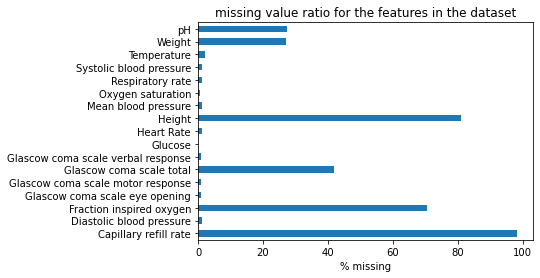

In [30]:
ax = na_df[1:-1].plot.barh(title='missing value ratio for the features in the dataset')
ax.set_xlabel("% missing")

### 2.1 drop features

exclude Height, Capillary refill rate due to high proportion of missing values (>75%)

In [31]:
df = df.drop(columns = ['Height', 'Capillary refill rate'])

In [32]:
df

,icustay id,Diastolic blood pressure,Fraction inspired oxygen,Glascow coma scale eye opening,Glascow coma scale motor response,Glascow coma scale total,Glascow coma scale verbal response,Glucose,Heart Rate,Mean blood pressure,Oxygen saturation,Respiratory rate,Systolic blood pressure,Temperature,Weight,pH,label
0,58313_episode1_timeseries.csv,74.0,0.95,4.0,5.0,NaN,4.0,140.0,100.0,91.0,96.0,25.0,141.0,37.055556,52.389876,7.40,0.0
1,9498_episode1_timeseries.csv,46.0,NaN,4.0,6.0,15.0,5.0,127.0,93.0,61.0,94.0,19.0,96.0,36.000002,NaN,7.37,0.0
2,31641_episode2_timeseries.csv,48.0,NaN,3.0,6.0,NaN,5.0,138.0,66.0,72.0,97.0,16.0,115.0,36.111111,71.350022,NaN,0.0
3,66015_episode2_timeseries.csv,52.0,0.40,1.0,1.0,NaN,0.0,137.0,84.0,66.0,99.0,9.0,108.0,36.611111,68.265596,7.26,0.0
4,51795_episode1_timeseries.csv,85.0,NaN,4.0,6.0,NaN,5.0,144.0,114.0,96.0,97.0,30.0,132.0,37.055556,78.017824,7.48,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17898,76799_episode1_timeseries.csv,82.0,1.00,4.0,6.0,NaN,5.0,147.0,86.0,87.0,99.0,16.0,144.0,36.888889,90.809118,6.50,0.0
17899,99288_episode1_timeseries.csv,35.0,0.40,3.0,6.0,NaN,0.0,184.0,64.0,61.0,100.0,16.0,137.0,36.777778,117.000000,7.36,0.0
17900,29502_episode2_timeseries.csv,71.0,NaN,4.0,6.0,15.0,5.0,88.0,102.0,83.0,98.0,17.0,125.0,37.055599,71.000000,NaN,0.0
17901,77280_episode1_timeseries.csv,62.0,NaN,4.0,6.0,NaN,4.0,119.0,67.0,73.0,100.0,11.0,114.0,35.555556,74.000000,7.42,0.0


In [33]:
X = df.iloc[:, 1:-1].values
y = df.iloc[:, -1].values

In [34]:
print(X.shape)
print(y.shape)

(17903, 15)
(17903,)


### 2.2 kNN imputation for missing values

In [35]:
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
# fit on the dataset
imputer.fit(X)

KNNImputer()

In [36]:
# transform the dataset
Xtrans = imputer.transform(X)

In [37]:
# print total missing
print('Missing: %d' % sum(np.isnan(Xtrans).flatten()))

Missing: 0


In [38]:
X.shape

(17903, 15)

In [39]:
pd.DataFrame(data=np.hstack((Xtrans, y.reshape(-1, 1))), index=df['icustay id'], columns=df.keys()[1:]).to_csv('/home/e0205142/project/MIMIC_assignment1/data/train_corrected_encoded_imputed.csv', index=True)

## Oversampling training set

In [40]:
# from imblearn.over_sampling import RandomOverSampler
# # define oversampling strategy
# oversample = RandomOverSampler(sampling_strategy='minority')
# # fit and apply the transform
# X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)

### fix multicollinear features

In [41]:
df = pd.read_csv('/home/e0205142/project/MIMIC_assignment1/data/train_corrected_encoded_imputed.csv')

In [42]:
y = df.iloc[:, -1].values

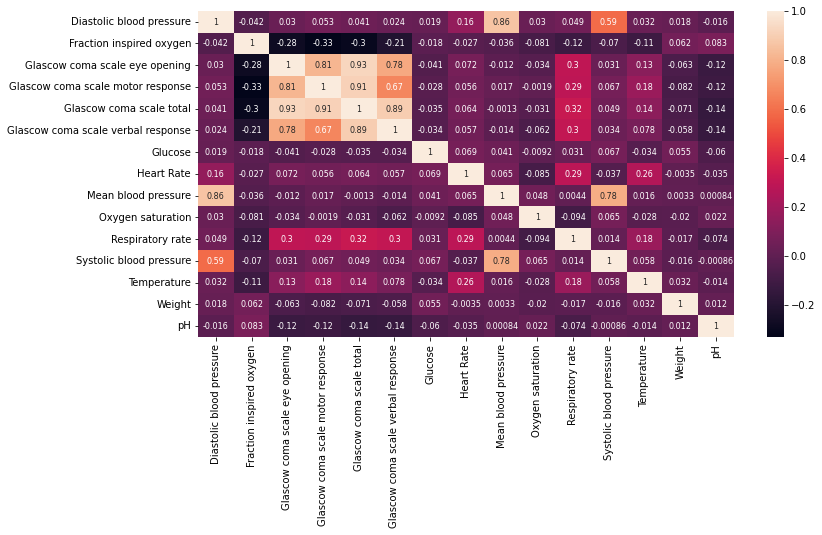

In [43]:
# calculate pearson correlation between features
var_cor = df.iloc[:, 1:-1].corr()

import seaborn as sns
plt.figure(figsize=[12, 6])
sns.heatmap(var_cor, annot=True, annot_kws={"fontsize":8})
plt.show()

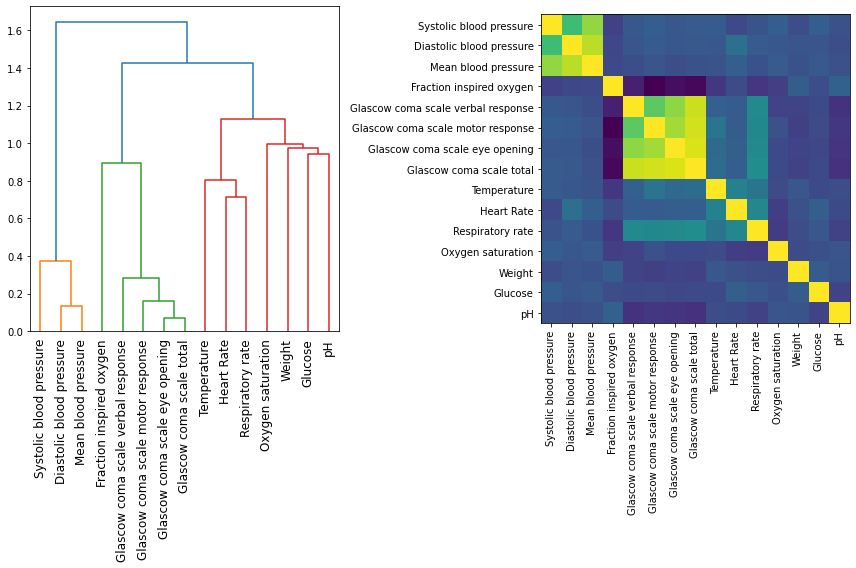

In [44]:
# One way to handle multicollinear features is by performing hierarchical clustering 
# on the correlations, picking a threshold, and keeping a single feature from each cluster. 
# First, we plot a heatmap of the correlated features:

from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
corr = var_cor.to_numpy()
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=var_cor.keys(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
fig.tight_layout()
plt.show()

In [45]:
# pick a threshold by visual inspection of the dendrogram to group features into clusters
# and choose a feature from each cluster to keep based on t-test.

from collections import defaultdict

cluster_ids = hierarchy.fcluster(dist_linkage, 0.5, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)

print(cluster_id_to_feature_ids)

selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

defaultdict(<class 'list'>, {1: [0, 8, 11], 3: [1], 2: [2, 3, 4, 5], 7: [6], 4: [7], 10: [9], 5: [10], 6: [12], 9: [13], 8: [14]})


In [46]:
print(selected_features)

[0, 1, 2, 6, 7, 9, 10, 12, 13, 14]


In [47]:
df = df.iloc[:,1:-1]
df = df.iloc[:, selected_features]

In [48]:
df

,Diastolic blood pressure,Fraction inspired oxygen,Glascow coma scale eye opening,Glucose,Heart Rate,Oxygen saturation,Respiratory rate,Temperature,Weight,pH
0,0.496644,0.950,1.000000,0.115702,0.526316,0.96,0.217391,0.677536,0.209560,0.700
1,0.308725,0.820,1.000000,0.104959,0.489474,0.94,0.165217,0.608695,0.294758,0.685
2,0.322148,0.836,0.666667,0.114050,0.347368,0.97,0.139130,0.615941,0.285400,0.612
3,0.348993,0.400,0.000000,0.113223,0.442105,0.99,0.078261,0.648550,0.273062,0.630
4,0.570470,0.560,1.000000,0.119008,0.600000,0.97,0.260870,0.677536,0.312071,0.740
...,...,...,...,...,...,...,...,...,...,...
17898,0.550336,1.000,1.000000,0.121488,0.452632,0.99,0.139130,0.666666,0.363236,0.250
17899,0.234899,0.400,0.666667,0.152066,0.336842,1.00,0.139130,0.659420,0.468000,0.680
17900,0.476510,0.680,1.000000,0.072727,0.536842,0.98,0.147826,0.677538,0.284000,0.711
17901,0.416107,0.640,1.000000,0.098347,0.352632,1.00,0.095652,0.579709,0.296000,0.710


In [49]:
np.unique(y, return_counts=True)

(array([0., 1.]), array([15480,  2423]))

In [76]:
df.keys()

Index(['Diastolic blood pressure', 'Fraction inspired oxygen',
       'Glascow coma scale eye opening', 'Glucose', 'Heart Rate',
       'Oxygen saturation', 'Respiratory rate', 'Temperature', 'Weight', 'pH'],
      dtype='object')

## Dataset split

In [50]:
X = df.iloc[:, :].values

print(X.shape)
print(y.shape)

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

(17903, 10)
(17903,)


## Baseline (after oversampling before feature selection)

In [51]:
models = [
          ('LR', LogisticRegression(class_weight = 'balanced')), 
          ('DT', DecisionTreeClassifier(class_weight = 'balanced')),
          ('RF', RandomForestClassifier(class_weight = 'balanced')),
          ('AdaBoost', AdaBoostClassifier(n_estimators=1000)),
          ('GBM', GradientBoostingClassifier(n_estimators=1000)),
          ('SVM', SVC(probability=True, class_weight = 'balanced'))
        ]

# Parameter tuning grids-------------------------
LR_params = [{'C': [ 10, 1.0, 0.1, 0.01]}]
DT_params = [{}]
RF_params = [{'n_estimators': [50, 100, 500]}]
Gradient_params = [{'learning_rate': [0.001, 0.01, 0.1], 'n_estimators': [500, 1000], 'subsample': [0.5, 0.7, 1.0], 'max_depth': [3, 7, 9]}]
Ada_params = [{'learning_rate': [0.001, 0.01, 0.1], 'n_estimators': [500, 1000], 'base_estimator': [DecisionTreeClassifier(max_depth=1, class_weight = 'balanced'), DecisionTreeClassifier(max_depth=5, class_weight = 'balanced')]}]
SVM_params =[{'kernel': ['linear', 'poly', 'rbf'], 'C': [100, 10, 1.0, 0.1, 0.001]}]

my_grid ={'LR': LR_params,
         'DT': DT_params,
         'RF': RF_params,
         'AdaBoost': Ada_params,
         'GBM': Gradient_params,
         'SVM': SVM_params}

# Model Training and Evaluation-------------------
train_acc, test_acc, train_auc, test_auc = [], [], [], []
names = []
runtimes = []
best_params = []
clfs = []

for name, model in models:
    start_time = time.time()
    
    clf = GridSearchCV(model, my_grid[name], cv = 5, scoring='roc_auc', n_jobs=10)
    clf.fit(X_train, y_train)

    y_train_pred = clf.predict(X_train)
    y_train_score = clf.predict_proba(X_train)
    y_test_pred = clf.predict(X_test)
    y_test_score = clf.predict_proba(X_test)
    #cv_results.append(cv_result)
    runtime = (time.time() - start_time)
    
    train_acc.append(balanced_accuracy_score(y_train, y_train_pred))
    test_acc.append(balanced_accuracy_score(y_test, y_test_pred))
    train_auc.append(roc_auc_score(y_train, y_train_score[:, 1]))
    test_auc.append(roc_auc_score(y_test, y_test_score[:, 1]))
    
    best_params.append(clf.best_params_)
    clfs.append(clf)
    
    names.append(name)
    runtimes.append(runtime)
    print("---%s finished in %s seconds ---" % (name, runtime))
    print('>%s: test AUC %.3f' % (name, roc_auc_score(y_test, y_test_score[:, 1])))

scores_df = pd.DataFrame({'train_acc':train_acc, 
                          'test_acc':test_acc, 
                          'train_auc':train_auc,
                          'test_auc':test_auc, 
                          'runtime(s)':runtimes}, index=names)

---LR finished in 8.252235174179077 seconds ---
>LR: test AUC 0.661
---DT finished in 0.3276820182800293 seconds ---
>DT: test AUC 0.528
---RF finished in 17.16439390182495 seconds ---
>RF: test AUC 0.699
---AdaBoost finished in 96.26667404174805 seconds ---
>AdaBoost: test AUC 0.685
---GBM finished in 513.5383820533752 seconds ---
>GBM: test AUC 0.717
---SVM finished in 642.0377128124237 seconds ---
>SVM: test AUC 0.715


In [52]:
# save data
# 1. scores and running time
scores_df.to_csv('/home/e0205142/project/MIMIC_assignment1/results/baseline_after_all_preprocess_before_feature_selection.csv', index=True)

# 2. model parameters
with open('/home/e0205142/project/MIMIC_assignment1/results/all_models_best_params.txt', 'w') as f:
    for name, para in zip(names, best_params):
        print(name, para, file=f)

# 3. models
with open('/home/e0205142/project/MIMIC_assignment1/results/clfs.pkl','wb') as f :
    pickle.dump(clfs, f, protocol=pickle.HIGHEST_PROTOCOL)
    f.close()

## Feature selection

In [53]:
# # define oversampling strategy
# oversample = RandomOverSampler(sampling_strategy='minority')
# # fit and apply the transform
# X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)

## Genetic algrithom

In [54]:
# estimators = LogisticRegression(solver="liblinear", multi_class="ovr")
# estimators = RandomForestClassifier(n_estimators = 100)
# selectors = GeneticSelectionCV(estimators,
#                                   cv=5,
#                                   verbose=2,
#                                   scoring="roc_auc",
#                                   max_features=10,
#                                   n_population=60,
#                                   crossover_proba=0.6,
#                                   mutation_proba=0.2,
#                                   n_generations=40,
#                                   crossover_independent_proba=0.6,
#                                   mutation_independent_proba=0.06,
#                                   tournament_size=4,
#                                   n_gen_no_change=20,
#                                   caching=True,
#                                   n_jobs=10)
# selectors = selectors.fit(X_train_over, y_train_over)

# print(selectors.support_)


## SVM-RFE

In [55]:
# # automatically choose the number of features
# rfe = RFECV(estimator=SVC())

### Permutation scores

In [56]:
start_time = time.time()

selector = RandomForestClassifier(random_state=42, n_jobs = 2, n_estimators=500, class_weight = 'balanced')
selector.fit(X_train, y_train)

perm_score = permutation_importance(selector, X_train, y_train, n_repeats=10, random_state=42, n_jobs=5)
#sorted_idx = perm_score.importances_mean.argsort() # from low to high

print("---Feature selection finished in %s seconds ---" %  (time.time() - start_time))

---Feature selection finished in 31.705532789230347 seconds ---


In [57]:
sorted_idx = perm_score.importances_mean.argsort() # from low to high
sorted_idx

array([5, 9, 1, 2, 8, 7, 3, 0, 4, 6])

In [75]:
perm_score.importances[sorted_idx][-1].mean()

0.04704403686807559

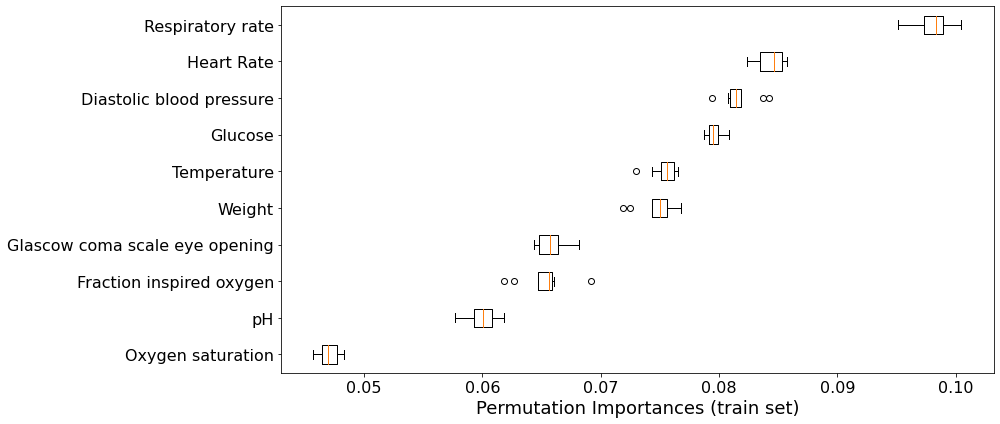

In [58]:
fig, ax = plt.subplots(figsize=(14,6))
ax.boxplot(perm_score.importances[sorted_idx].T, vert=False, labels=df.iloc[:, :].columns[sorted_idx])
plt.xlabel('Permutation Importances (train set)', fontsize=18)
plt.xticks(fontsize= 16)
plt.yticks(fontsize= 16)
fig.tight_layout()
plt.show()

In [59]:
parsi = {}
scoring = {'acc': 'accuracy',
           'auc': 'roc_auc'}

sorted_idx = sorted_idx[::-1]

val_auc = []
val_acc = []

for k in range(len(sorted_idx)):
    subset = X_train[:, sorted_idx[:k+1]]
    selector.fit(subset, y_train)
    
    y_val_pred = selector.predict(X_val[:, sorted_idx[:k+1]])
    y_val_score = selector.predict_proba(X_val[:, sorted_idx[:k+1]])

    #cv_results.append(cv_result)
    runtime = (time.time() - start_time)
    
    val_acc.append(accuracy_score(y_val, y_val_pred))
    val_auc.append(roc_auc_score(y_val, y_val_score[:, 1]))

    print(k)

0
1
2
3
4
5
6
7
8
9


In [60]:
print(val_auc)
print(val_acc)

[0.5768090366326424, 0.530853725621262, 0.580290691701378, 0.5844043700639435, 0.6230406952776416, 0.6272395537343344, 0.6742635173006624, 0.6843898699410502, 0.6918454039812265, 0.6840257412943993]
[0.5847528623289584, 0.7070650656241273, 0.8335660430047472, 0.854789165037699, 0.8573024294889695, 0.8600949455459369, 0.8612119519687238, 0.8612119519687238, 0.8603741971516337, 0.8606534487573304]


No handles with labels found to put in legend.


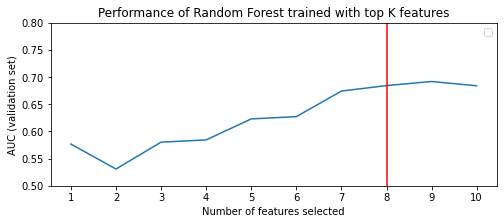

In [61]:
plt.figure(figsize=[8, 3])
plt.xlabel("Number of features selected")
plt.ylabel("AUC (validation set)")
plt.title("Performance of Random Forest trained with top K features")
plt.plot(range(1,11), val_auc)
plt.ylim([0.5, 0.8])
plt.axvline(x=8, c = 'r')
plt.xticks(range(1,11))
plt.legend()
plt.show()

## Model Evaluation

In [62]:
# RF-permutation
X_train_selected = X_train[:, sorted_idx[:8]]
X_test_selected = X_test[:, sorted_idx[:8]]

In [63]:
models = [
          ('LR', LogisticRegression(class_weight = 'balanced')), 
          ('DT', DecisionTreeClassifier(class_weight = 'balanced')),
          ('RF', RandomForestClassifier(class_weight = 'balanced')),
          ('AdaBoost', AdaBoostClassifier(n_estimators=1000)),
          ('GBM', GradientBoostingClassifier(n_estimators=1000)),
          ('SVM', SVC(probability=True, class_weight = 'balanced'))
        ]

# Parameter tuning grids-------------------------
LR_params = [{'C': [ 10, 1.0, 0.1, 0.01]}]
DT_params = [{}]
RF_params = [{'n_estimators': [50, 100, 500]}]
Gradient_params = [{'learning_rate': [0.001, 0.01, 0.1], 'n_estimators': [500, 1000], 'subsample': [0.5, 0.7, 1.0], 'max_depth': [3, 7, 9]}]
Ada_params = [{'learning_rate': [0.001, 0.01, 0.1], 'n_estimators': [500, 1000], 'base_estimator': [DecisionTreeClassifier(max_depth=1, class_weight = 'balanced'), DecisionTreeClassifier(max_depth=5, class_weight = 'balanced')]}]
SVM_params =[{'kernel': ['linear', 'poly', 'rbf'], 'C': [100, 10, 1.0, 0.1, 0.001]}]

my_grid ={'LR': LR_params,
         'DT': DT_params,
         'RF': RF_params,
         'AdaBoost': Ada_params,
         'GBM': Gradient_params,
         'SVM': SVM_params}

# evaluate all the models
train_acc, test_acc, train_auc, test_auc = [], [], [], []
names = []
cv_results = []
best_params = []
clfs = []
runtimes = []

for name, model in models:
    start_time = time.time()

    
    clf = GridSearchCV(model, my_grid[name], cv = 5, scoring='roc_auc', n_jobs=10)
    clf.fit(X_train_selected, y_train)

    y_train_pred = clf.predict(X_train_selected)
    y_train_score = clf.predict_proba(X_train_selected)
    y_test_pred = clf.predict(X_test_selected)
    y_test_score = clf.predict_proba(X_test_selected)
    #cv_results.append(cv_result)
    
    train_acc.append(balanced_accuracy_score(y_train, y_train_pred))
    test_acc.append(balanced_accuracy_score(y_test, y_test_pred))
    train_auc.append(roc_auc_score(y_train, y_train_score[:, 1]))
    test_auc.append(roc_auc_score(y_test, y_test_score[:, 1]))
    
    best_params.append(clf.best_params_)
    clfs.append(clf)
    
    names.append(name)
    
    runtime = (time.time() - start_time)
    runtimes.append(runtime)
    print("---%s finished in %s seconds ---" % (name, runtime))
    print('>%s: test AUC %.3f' % (name, roc_auc_score(y_test, y_test_score[:, 1])))


---LR finished in 1.5278804302215576 seconds ---
>LR: test AUC 0.660
---DT finished in 0.2661285400390625 seconds ---
>DT: test AUC 0.521
---RF finished in 13.986124515533447 seconds ---
>RF: test AUC 0.685
---AdaBoost finished in 84.11627054214478 seconds ---
>AdaBoost: test AUC 0.674
---GBM finished in 463.5323829650879 seconds ---
>GBM: test AUC 0.698
---SVM finished in 566.2392027378082 seconds ---
>SVM: test AUC 0.703


In [64]:
scores_df = pd.DataFrame({'train_acc':train_acc, 
                          'test_acc':test_acc, 
                          'train_auc':train_auc,
                          'test_auc':test_auc, 
                          'runtime(s)': runtimes}, index=names)
print(scores_df)

          train_acc  test_acc  train_auc  test_auc  runtime(s)
LR         0.599617  0.615729   0.645737  0.660389    1.527880
DT         1.000000  0.520839   1.000000  0.520839    0.266129
RF         1.000000  0.500901   1.000000  0.685101   13.986125
AdaBoost   0.642755  0.635376   0.705205  0.673631   84.116271
GBM        0.524088  0.500000   0.926431  0.697578  463.532383
SVM        0.661155  0.651143   0.722510  0.702637  566.239203


In [65]:
scores_df.to_csv('/home/e0205142/project/MIMIC_assignment1/results/final_models_evaluation.csv', index=True)

In [66]:
with open('/home/e0205142/project/MIMIC_assignment1/results/final_models_best_params.txt', 'w') as f:
    for name, para in zip(names, best_params):
        print(name, para, file=f)

In [67]:
with open('/home/e0205142/project/MIMIC_assignment1/results/final_clfs.pkl','wb') as f :
    pickle.dump(clfs, f, protocol=pickle.HIGHEST_PROTOCOL)
    f.close()